# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-93-dry-bean-classification/298/overview/about

# Methodology:
1.

### Import all libraries required

In [154]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb

### Declare the path

In [2]:
train_path = '/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,69892,1052.973,389.855771,228.671466,1.704873,0.80991,71139,298.310674,0.68427,0.982471,0.792142,0.765182,0.005578,0.00118,0.585504,0.998209,BARBUNYA


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,43514,792.22,300.349775,185.116129,1.622494,0.787484,43961,235.380002,0.688469,0.989832,0.871259,0.783686,0.006902,0.001606,0.614164,0.996478


In [8]:
d = {value: idx for idx, value in enumerate(train_df.Class.unique())}
d

{'BARBUNYA': 0,
 'DERMASON': 1,
 'BOMBAY': 2,
 'SIRA': 3,
 'CALI': 4,
 'HOROZ': 5,
 'SEKER': 6}

In [11]:
d_rev = {value:key for key, value in d.items()}
d_rev

{0: 'BARBUNYA',
 1: 'DERMASON',
 2: 'BOMBAY',
 3: 'SIRA',
 4: 'CALI',
 5: 'HOROZ',
 6: 'SEKER'}

In [12]:
train_df['Class'] = train_df['Class'].map(d)

In [13]:
train_df.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000
mean,53313.700400,856.897475,320.613592,202.656362,1.582931,0.750977,54038.396400,253.490510,0.749295,0.987125,0.873166,0.799917,0.006557,0.001714,0.643659,0.995023,2.9812
std,30159.132787,217.871670,86.553220,46.016190,0.247091,0.091147,30616.360546,60.208996,0.049619,0.004610,0.060540,0.061594,0.001130,0.000594,0.098673,0.004497,2.0076
min,21348.000000,530.825000,187.168635,131.433059,1.060798,0.333680,21590.000000,164.866970,0.566669,0.949023,0.556766,0.648762,0.002778,0.000590,0.420892,0.949990,0.0000
25%,36417.750000,702.814000,252.902269,175.667281,1.432151,0.715854,36788.750000,215.333507,0.719277,0.985603,0.831385,0.763542,0.005921,0.001156,0.582996,0.993657,1.0000
50%,44751.000000,794.969000,296.498005,192.837885,1.549432,0.763847,45288.000000,238.702205,0.759512,0.988283,0.883453,0.802000,0.006634,0.001702,0.643203,0.996385,3.0000
75%,61028.750000,977.501750,376.493680,216.171558,1.704654,0.809856,61951.000000,278.754756,0.786154,0.989946,0.917277,0.833927,0.007283,0.002176,0.695435,0.997951,5.0000
max,254616.000000,1985.370000,738.860153,460.198497,2.364017,0.906126,263261.000000,569.374358,0.852841,0.993820,0.986685,0.970516,0.009720,0.003665,0.941900,0.999733,6.0000


In [15]:
train_df.shape, test_df.shape

((2500, 17), (2500, 16))

# Drop duplicate rows

In [16]:
train_df[train_df.duplicated()]

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
2469,59105,957.363,372.981361,205.54524,1.814595,0.834448,60667,274.326126,0.75763,0.974253,0.810365,0.735496,0.00631,0.001139,0.540954,0.981612,5


In [17]:
train_df.drop_duplicates(inplace=True)
train_df.shape

(2499, 17)

# Separate into dependent and independent features

In [227]:
train_X = train_df.drop('Class', axis=1).copy()
train_y = train_df['Class'].copy()
final_X = test_df.copy()

# Visualize the data

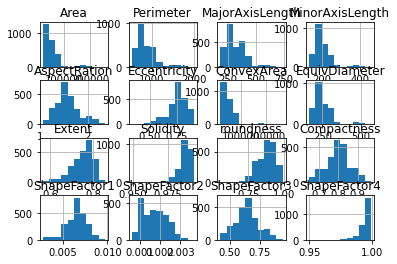

In [19]:
train_X.hist()
plt.show()

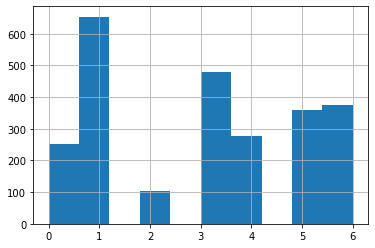

In [20]:
train_y.hist()
plt.show()

# Scaling

In [228]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
final_X = scaler.transform(final_X)

# Train Test Split

In [229]:
train_y = train_y.to_numpy()
# train_X = train_X.to_numpy()

In [77]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=1)

# Cross Validation for model selection

# Define the models for classification

In [230]:
models = {
#     'LOG': LogisticRegression(max_iter=500, solver='liblinear'),
         'LDA': LinearDiscriminantAnalysis(),
         'KNN': KNeighborsClassifier(n_jobs=4),
         'GNB': GaussianNB(),
         'DCT': DecisionTreeClassifier(),
         'SVM': SVC(),
          'RFC': RandomForestClassifier(n_jobs=4),
          'ADA': AdaBoostClassifier(),
         'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4),
        }

# Evaluate each model in turn using cross validation score on the training data. Metrics: Accuracy, Precision, Recall, F1 Score

In [231]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"{name}: Acc: {cv_results['test_score'].mean():.3f}")

LDA: Acc: 0.899
KNN: Acc: 0.600
GNB: Acc: 0.754
DCT: Acc: 0.877
SVM: Acc: 0.634
RFC: Acc: 0.907
ADA: Acc: 0.571
XGB: Acc: 0.910


# LGBM

In [232]:
# X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=1)
hyper_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'classification', 
                'learning_rate': 0.08, 'n_estimators':10000,'verbose': -1, 
                'random_state':1, 'max_depth': -1, 'colsample_bytree': 0.9, 'num_leaves': 64, 
                'max_bin': 128, }
stopper = lgb.early_stopping(stopping_rounds=100)
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    gbm = lgb.LGBMClassifier(**hyper_params) 
    gbm.fit(train_X[train_id], train_y[train_id], eval_set=[(train_X[test_id], train_y[test_id])], callbacks=[stopper],verbose='warn')
    preds_gbm = gbm.predict(train_X[test_id], num_iteration=gbm.best_iteration_)
    a = acc(train_y[test_id], preds_gbm)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.237129
Fold:1, Acc: 0.9180
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.211397
Fold:2, Acc: 0.9300
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.211397
Fold:3, Acc: 0.9200
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.211397
Fold:4, Acc: 0.9140
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.211397
Fold:5, Acc: 0.9259
Final: Acc: 0.9216


### Final: Acc: 0.9224

In [233]:
hyper_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'classification', 
                'learning_rate': 0.08, 'n_estimators':42,'verbose': -1, 
                'random_state':1, 'max_depth': -1, 'colsample_bytree': 0.9, 'num_leaves': 128, 
                'max_bin': 128, }
gbm = lgb.LGBMClassifier(**hyper_params) 
gbm.fit(train_X, train_y, verbose='warn')

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.08, max_bin=128,
               n_estimators=42, num_leaves=128, objective='classification',
               random_state=1, task='train', verbose=-1)

In [234]:
test_df['Class'] = gbm.predict(final_X[:,:16])
test_df['Class'] = test_df['Class'].map(d_rev)
test_df['Class'].to_csv('/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/submission/sub7.csv', 
                   index=False)
test_df['Class']

0           SIRA
1           CALI
2          HOROZ
3          SEKER
4           CALI
          ...   
2495        SIRA
2496    DERMASON
2497       HOROZ
2498        SIRA
2499       SEKER
Name: Class, Length: 2500, dtype: object

In [173]:
final_X['Class'] = gbm.predict(final_X.iloc[:,:16])
final_X['Class'] = final_X['Class'].map(d_rev)
final_X['Class'].to_csv('/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/submission/sub4.csv', 
                   index=False)
final_X['Class']

0           SIRA
1           CALI
2          HOROZ
3          SEKER
4           CALI
          ...   
2495        SIRA
2496    DERMASON
2497       HOROZ
2498        SIRA
2499       SEKER
Name: Class, Length: 2500, dtype: object

# XGB Classifier

In [185]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, random_state=1,
            n_estimators=100, max_depth=20, learning_rate=0.1, booster='gbtree', num_parallel_tree=1,
            colsample_bytree=0.9, colsample_bylevel=1, colsample_bynode=1, 
                         )
    model_xgb.fit(train_X[train_id], train_y[train_id])
    preds_xgb = model_xgb.predict(train_X[test_id])
    a = acc(train_y[test_id], preds_xgb)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Fold:1, Acc: 0.9180
Fold:2, Acc: 0.9260
Fold:3, Acc: 0.9080
Fold:4, Acc: 0.9120
Fold:5, Acc: 0.9118
Final: Acc: 0.9152


### Final: Acc: 0.9160 nt 1

In [186]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, random_state=1,
            n_estimators=100, max_depth=20, learning_rate=0.1, booster='gbtree', num_parallel_tree=1,
            colsample_bytree=0.9, colsample_bylevel=1, colsample_bynode=1, 
                         )
model_xgb.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [187]:
final_X['Class'] = model_xgb.predict(final_X.iloc[:,:16])
final_X['Class'] = final_X['Class'].map(d_rev)
final_X['Class'].to_csv('/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/submission/sub5.csv', 
                   index=False)
final_X['Class']

0           SIRA
1           CALI
2          HOROZ
3          SEKER
4           CALI
          ...   
2495        SIRA
2496    DERMASON
2497       HOROZ
2498        SIRA
2499       SEKER
Name: Class, Length: 2500, dtype: object

# RF Classifier

In [224]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    model_rfc = RandomForestClassifier(n_jobs=4, random_state=1,
        n_estimators=100, criterion='gini',  max_depth=8, max_features=0.95, )
    model_rfc.fit(train_X[train_id], train_y[train_id])
    preds_rfc = model_rfc.predict(train_X[test_id])
    a = acc(train_y[test_id], preds_rfc)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Fold:1, Acc: 0.9240
Fold:2, Acc: 0.9260
Fold:3, Acc: 0.9100
Fold:4, Acc: 0.9200
Fold:5, Acc: 0.9138
Final: Acc: 0.9188


### Final: Acc: 0.9212 none

In [225]:
model_rfc = RandomForestClassifier(n_jobs=4, random_state=1,
        n_estimators=100, criterion='gini',  max_depth=8, max_features=0.95)
model_rfc.fit(train_X, train_y)

RandomForestClassifier(max_depth=8, max_features=0.95, n_jobs=4, random_state=1)

In [226]:
final_X['Class'] = model_rfc.predict(final_X.iloc[:,:16])
final_X['Class'] = final_X['Class'].map(d_rev)
final_X['Class'].to_csv('/home/sandeep/Development/Datasets/Agriculture/dphi_ds93_dry_bean/submission/sub6.csv', 
                   index=False)
final_X['Class']

/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0           SIRA
1           CALI
2          HOROZ
3          SEKER
4           CALI
          ...   
2495        SIRA
2496    DERMASON
2497       HOROZ
2498        SIRA
2499       SEKER
Name: Class, Length: 2500, dtype: object

In [83]:
for i in [0.1,0.15,0.2,0.25]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    fold=0
    res = {'Acc':[], 'Prec':[],'Rec':[],'F1':[]}
    for train_id, test_id in kfold.split(X_train, y_train):
        fold+=1
        model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, random_state=1,
                    n_estimators=300, max_depth=30, learning_rate=i, booster='gbtree', num_parallel_tree=1,
                    colsample_bytree=0.5, colsample_bylevel=1, colsample_bynode=1)
        model_xgb.fit(X_train[train_id], y_train[train_id])
        preds_xgb = model_xgb.predict(X_train[test_id])
        a = acc(y_train[test_id], preds_xgb);    p = ps(y_train[test_id], preds_xgb);
        r = rs(y_train[test_id], preds_xgb);    f = f1(y_train[test_id], preds_xgb);
#         print(f'Fold:{fold}, Acc: {a:0.4f}, Prec: {p:0.4f}, Rec: {r:0.4f}, F1: {f:0.4f}')
        res['Acc'].append(a);     res['Prec'].append(p);    res['Rec'].append(r);    res['F1'].append(f) ;
    print(f"MD:{i}, Acc: {np.array(res['Acc']).mean():0.4f}, Prec: {np.array(res['Prec']).mean():0.4f},\
    Rec: {np.array(res['Rec']).mean():0.4f}, F1: {np.array(res['F1']).mean():0.4f}")

MD:0.1, Acc: 0.8910, Prec: 0.8831,    Rec: 0.9026, F1: 0.8927
MD:0.15, Acc: 0.8927, Prec: 0.8847,    Rec: 0.9046, F1: 0.8944
MD:0.2, Acc: 0.8933, Prec: 0.8853,    Rec: 0.9048, F1: 0.8949
MD:0.25, Acc: 0.8927, Prec: 0.8852,    Rec: 0.9037, F1: 0.8943
